Reading the "Reducing the Dimensionality of data with neural networks" paper by G. E. Hinton* and R. R. Salakhutdinov - https://www.cs.toronto.edu/~hinton/absps/science.pdf

Dimensionality reduction is the process of transforming data from a high dimensional space to a lower dimensional space (3D to 2D) while preserving as much information as possible during the reduction. It is useful because working with high dimensional data has some disadvantages (https://en.wikipedia.org/wiki/Curse_of_dimensionality) - more data is needed and organizing it is generally harder.

# Loading MNIST

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform)

test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64,
                                               shuffle=True, num_workers=2)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64,
                                              shuffle=True, num_workers=2)

# Visualizing an image from MNIST

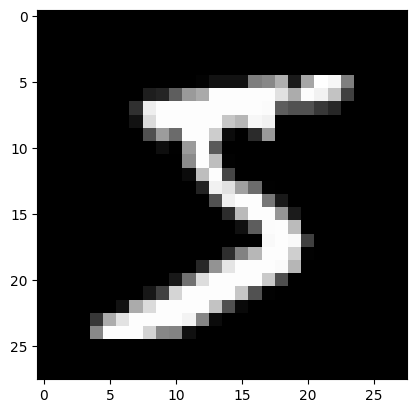

In [ ]:
def show_image(image):
    plt.imshow(image.squeeze(), cmap='gray')
    plt.show()
    
x = train_dataloader.dataset[0][0]

show_image(x)

There are a few methods for reducing the dimensionality - heatmaps, t-SNE, Multi-Dimensional Scaling, etc. A pretty simple and standard way of reducing the dimensionality is a method called Principal Component Analysis (PCA):

# Applying Principal Component Analysis (PCA):

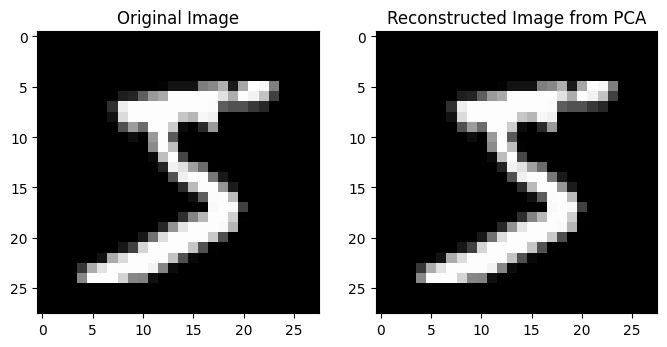

In [ ]:
x_flattened = x.view(-1)

mean_x = torch.mean(x_flattened)

# Compute the covariance matrix
centered_image = x_flattened - mean_x
covariance_matrix = torch.mm(centered_image.unsqueeze(1), centered_image.unsqueeze(0)) / (x_flattened.numel() - 1)

# Compute the eigenvectors using SVD
_, s, v = torch.svd(covariance_matrix)

# Project the data onto the principal components
num_components = 10  # You can choose any desired number of principal components
principal_components = v[:, :num_components].t()  # Transpose for proper matrix multiplication
projected_data = torch.mm(centered_image.unsqueeze(0), principal_components.t())

# Reconstruct the data from the principal components
reconstructed_data = torch.mm(projected_data, principal_components) + mean_x.view(1, -1)

# Reshape the reconstructed data back to the original image size
reconstructed_image = reconstructed_data.view(x.size())

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(x.squeeze(), cmap='gray')
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image.squeeze().detach(), cmap='gray')
plt.title('Reconstructed Image from PCA')
plt.show()

# Using Autoencoder for dimensionality reduction

### Naive Deep Autoencoder

In [ ]:
from torchvision.utils import make_grid

def display_output(v0, vk, dim1=28, dim2=28, v0_fname=None, vk_fname=None):
    print("Original (top) and Reconstructed (bottom)")
    img = make_grid(v0.view(v0.shape[0], 1, dim1, dim2).data)
    npimg = np.transpose(img.detach().numpy(), (1, 2, 0))
    plt.imshow(npimg)
    if v0_fname is not None:
        plt.savefig(v0_fname)
    plt.show()
    img = make_grid(vk.view(vk.shape[0], 1, dim1, dim2).data)
    npimg = np.transpose(img.detach().numpy(), (1, 2, 0))
    plt.imshow(npimg)
    if vk_fname is not None:
        plt.savefig(vk_fname)    
    plt.show()

Epoch 0: 0.06812627567871929
Epoch 1: 0.06748508224720513
Epoch 2: 0.0674170073090014
Epoch 3: 0.05644135574287951
Epoch 4: 0.04337272547614346
Epoch 5: 0.04005448009445469
Epoch 6: 0.03866825319492995
Epoch 7: 0.03767149744313091
Epoch 8: 0.03700024027353538
Epoch 9: 0.03661602332211062
Original (top) and Reconstructed (bottom)


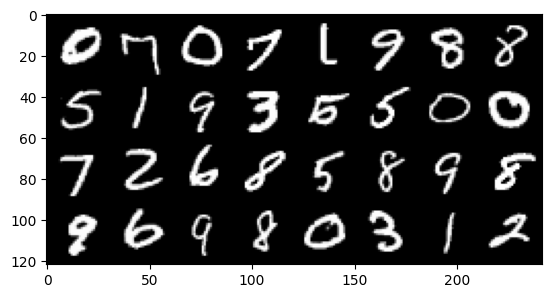

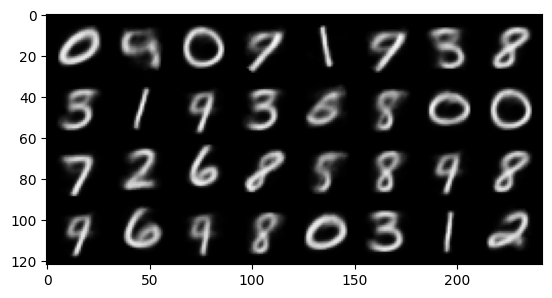

In [ ]:
import os
import sys

module_path = os.path.abspath('.')
if module_path not in sys.path:
    sys.path.append(module_path)

from restricted_boltzmann_machine import RestrictedBoltzmannMachine
from deep_autoencoder import DeepAutoencoder, NaiveDeepAutoencoder
from torch import nn
from torch import optim

pixels = 784

def flatten_input(dataloader):
    flat_input = []
    labels = []
    for features, targets in dataloader:
        flat_input.append(features.view(-1, pixels).detach().numpy())
        labels.append(targets.detach().numpy())
    return np.concatenate(flat_input), np.concatenate(labels)


flat_train_input, train_labels = flatten_input(train_dataloader)
flat_test_input, test_labels = flatten_input(test_dataloader)
train_dataloader_flat = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(
    torch.Tensor(flat_train_input)), batch_size=64, shuffle=False)

learning_rate = 1e-3
naive_deep_autoencoder = NaiveDeepAutoencoder([784, 1000, 500, 250, 2])
loss = nn.MSELoss()
optimizer = optim.Adam(naive_deep_autoencoder.parameters(), learning_rate)
epochs = 10

running_loss = float("inf")
for epoch in range(epochs):
    losses = []
    for i, data_list in enumerate(train_dataloader_flat):
      data = data_list[0]
      v_pred = naive_deep_autoencoder(data)
      batch_loss = loss(data, v_pred)
      losses.append(batch_loss.item())
      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()
    running_loss = np.mean(losses)
    print(f"Epoch {epoch}: {running_loss}")
    if epoch % 10 == 9:
      display_output(data, v_pred, v0_fname="./images/original_digits.png", vk_fname="./images/reconstructed_digits_naive_dae.png")


We can see that the naive implementation of the autoencoder compresses the data but a lot of information is lost in the process.

### Restricted Boltzmann Machine

In [ ]:
hidden_dimensions = [
    {
        "hidden_dim": 1000, 
        "num_epochs": 10, 
        "learning_rate": 0.1, 
        "display_dim1": 28, 
        "display_dim2": 28, 
        "use_gaussian": False
    }, 
    {
        "hidden_dim": 500, 
        "num_epochs": 10, 
        "learning_rate": 0.1, 
        "display_dim1": 25, 
        "display_dim2": 40, 
        "use_gaussian": False
    },
    {
        "hidden_dim": 250, 
        "num_epochs": 10, 
        "learning_rate": 0.1, 
        "display_dim1": 25, 
        "display_dim2": 20, 
        "use_gaussian": False
    },
    {
        "hidden_dim": 2, 
        "num_epochs": 30, 
        "learning_rate": 0.001,
        "display_dim1": 25, 
        "display_dim2": 10, 
        "use_gaussian": True
    }
]

In [ ]:
import torch

module_path = os.path.abspath('.')
if module_path not in sys.path:
    sys.path.append(module_path)

from deep_autoencoder import DeepAutoencoder, NaiveDeepAutoencoder
from restricted_boltzmann_machine import RestrictedBoltzmannMachine

def train_restricted_boltzmann_machine(train_dl, visible_dim, hidden_dim, k, num_epochs, lr, use_gaussian=False):
    restricted_boltzmann_machine = RestrictedBoltzmannMachine(visible_dim=visible_dim, hidden_dim=hidden_dim, gaussian_hidden_distribution=use_gaussian)
    loss = torch.nn.MSELoss()

    for epoch in range(num_epochs):
        train_loss = 0
        for i, data_list in enumerate(train_dl):
            sample_data = data_list[0]
            v0, pvk = sample_data, sample_data
            
            # Gibbs sampling
            for i in range(k):
                _, hk = restricted_boltzmann_machine.sample_h(pvk)
                pvk = restricted_boltzmann_machine.sample_v(hk)
            
            ph0, _ = restricted_boltzmann_machine.sample_h(v0)
            phk, _ = restricted_boltzmann_machine.sample_h(pvk)
            
            restricted_boltzmann_machine.update_weights(v0, pvk, ph0, phk, lr, 
                               momentum_coef=0.5 if epoch < 5 else 0.9, 
                               weight_decay=2e-4, 
                               batch_size=sample_data.shape[0])
            
            train_loss += loss(v0, pvk)
        
        print(f"Epoch {epoch}: {train_loss/len(train_dl)}")
    return restricted_boltzmann_machine, v0, pvk

In [ ]:
new_train_dataloader = train_dataloader_flat

visible_dim = pixels
hidden_dim = None
models = []
for configs in hidden_dimensions:
    hidden_dim = configs["hidden_dim"]
    num_epochs = configs["num_epochs"]
    lr = configs["learning_rate"]
    d1 = configs["display_dim1"]
    d2 = configs["display_dim2"]
    use_gaussian = configs["use_gaussian"]
    
    print(f"{visible_dim} to {hidden_dim}")
    model, v, v_pred = train_restricted_boltzmann_machine(new_train_dataloader, visible_dim, hidden_dim, k=1, num_epochs=num_epochs, lr=lr, use_gaussian=use_gaussian)
    models.append(model)
    
    display_output(v, v_pred, d1, d2)

    new_data = []
    for data_list in new_train_dataloader:
        p = model.sample_h(data_list[0])[0]
        new_data.append(p.detach().numpy())
    new_input = np.concatenate(new_data)
    new_train_dataloader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.Tensor(new_input)), 
        batch_size=64, 
        shuffle=False
    )
    
    visible_dim = hidden_dim

NameError: name 'train_dataloader_flat' is not defined